# Predicting Daily Traded Option Volume Rank

**This project reflects the final project work done in FM 5323 - Data Science and Machine Learning (Fall of 2021)**
<br>
<br>
Contributing authors*: Whitney Rueckl, Ben Stark, Aura Salazar, and Amin Mirbod <br>

The contrbuting authors are students of the Master's of Financial Mathematics program at the University of Minnesota <br>

* Edited by Whitney Rueckl July 2022 - ran start to finish on 8/1/2022

## Introduction <br>
In this project we aim to predict daily option trading volume rank based on a combination of stock data as well as previous volume, open interest, and volatility data. 

We first engineer new features based on the stock and volume data and use a filter-based method to select best features. Followed by this, we use a recursive method to determine the optimal set of features to use for our Supervised and Deep Learning Models.

Next, we will fit a variety of learning models. Both non-Neural Network (Non-NN) and Neural Network (NN) models are tested.  Hyperparameter tuning techniques are applied where necessary to obtain the best fit models.

To conclude, we wrap up our results by comparing the goodness of fit metrics of both non-NN and NN models and testing their performance using a user-defined, top(N) backtest function.

#### Project Outline

##### Feature Selection and Engineering
* Pearson Correlation
* Recursive Importance Ranking <br>

[Jump to Feature Engineering](#feature_engineer) <br>

##### Supervised Learning Models:
* Lasso Regression
* KNN Regression
* Random Forest
* Gradient Boosted Trees for Regression (XGBoost)

[Jump to Fitting Learning Models](#variety_models) <br>

##### Neural Networks
* Optimizer and Hyper-Parameter Tuning
* Architectures, Regularization, and Normalization

We tested 3 architectures:
* deep: 2 layers with 128 nodes in each layer
* simple: single layer with 16 nodes
* shallow: 2 layers with 16 nodes in first layer and 32 in second layer

On these 3 architectures we tested normalization, and two forms of regularization:
* Normalization
* Drop out Regularization
* L2 Regularization


[Jump to Neural Network Models](#NN_models) <br>

##### Model Evaluation and Comparison
* Model performance was evaluated based on R-squared and mean-squared error
* Backtested all model <br>

[Jump to Model Comparison](#model_compare) <br>

## Project Summary and Conclusion

An important step in applying machine learning methods is feature selection. Choosing the right features will greatly impact your model's ability to accurately predict behavior. We used our own knowledge of factors that impact option volume, such as volatility moves and option liquidity, to come up with features that would reflect on these factors. This resulted in engineering new features that used realized volatility for different periods and open interest.

Followed by this, we used **Pearson Correlation** as a filter method in order to reduce dimensionality of the data. This was combined with **Recursive Feature Elimination** which allowed us to dig deeper into feature importance.

Once features were finalized with the above methods, we proceeded to fit a variety of models which were compared in performance against themselves and a simple rule-based estimator in order to get a better understanding on how the models improved the predictions. Model performance was measured by a high R-squared and low mean-square error. We ran **Lasso, KNN, Random Forest and Gradient Boosted Trees (XGBoost)** models and performed a **10-fold CV** as well as **GridSearch** to tune hyperparameters. *As expected, XGBoost had the best *R^2 and MSE* and it was also the model that performed best in the backtest when compared to Lasso, KNN, and Random Forest.*

*A considerable portion of this project was dedicated to exploring Neural Network learning models*. We tested three different network architectures. With each of the three architectures, we applied and tested normalization and two forms of regularization. We considered four important items to consider when fitting a neural network model: the loss function, the optimizer, the activation funcitons, and of course tuning of hyperparameters. 

When assessing the neural network performace, we compared results by comparing two Optimizers: **RMSprop and Adam**. Additionally, we assesed results when using two different Activation Functions **ReLu** and the **Sigmoid Activation function**. Performance was assesed based on goodnes-of-fit metrics R-squared and MSE. We concluded that the combination of the ReLu activation function and the Adam optimizer resulted in the lowest MSE and highest R^2 scores. Finally, we tuned the learning rate to use in the optimzer function.

To conclude the project, we compile all of our results and compare backtest performance and goodness-of-fit metrics: the MSE and R-squared. <br>

**The three best performing model based on the backtest and goodness of fit scores were the following:** <br>
- Deep neural network model with normalization
- XGBoost Gradient Boosted Trees (regression)
- Random Forest

[Jump to Conclusion](#conclusion) <br>

#### Import packages

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_rows = 15
%matplotlib inline

import time
import seaborn as sns
from matplotlib import pyplot as plt

import sklearn
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, f_regression

from bokeh.plotting import figure

# supress warnings
import warnings
warnings.filterwarnings('ignore')

#### Load data

In [2]:
df_stats = pd.read_csv('stats.csv')
df_stock = pd.read_csv('stock_quote.csv')

#### Some simple data wrangling

Create analysis dataset by filtering down on 2016 data

In [4]:
df_stats_2016 = df_stats.query('quotedate >= "2016-01-01"').query('quotedate <= "2016-12-31"')

Rank symbols by average daily volume

In [5]:
df_volume_rank = \
    (
    df_stats_2016
        .groupby(['symbol'])[['totalvol']].mean()
        .reset_index()
        .rename(columns={'totalvol':'average_daily_volume'})
        .assign(average_daily_volume = lambda df: np.round(df['average_daily_volume']))
        .assign(volume_rank = lambda df: df['average_daily_volume'].rank(ascending=False))
    )
df_volume_rank

,symbol,average_daily_volume,volume_rank
0,A,905.0,895.5
1,AA,39852.0,55.0
2,AAC,108.0,2118.0
3,AAL,37165.0,60.0
4,AAN,402.0,1308.0
...,...,...,...
4742,ZTO,358.0,1381.0
4743,ZTS,1945.0,589.5
4744,ZUMZ,206.0,1693.0
4745,ZX,0.0,4703.5


Select symbols ranked between 301 and 700 average daily volume

In [6]:
df_universe_raw = \
    (
    df_volume_rank
        .query('volume_rank >= 301 & volume_rank <= 700')
        .sort_values(['volume_rank'])
        [['symbol', 'average_daily_volume', 'volume_rank']]
    )
df_universe_raw

,symbol,average_daily_volume,volume_rank
624,BUD,5623.0,301.0
2159,IILG,5619.0,302.0
4032,TAP,5611.0,303.0
325,ASHR,5606.0,304.0
3301,POM,5565.0,305.0
...,...,...,...
2812,MTW,1441.0,696.0
957,CRC,1438.0,697.0
3296,PNRA,1432.0,698.5
1653,FNSR,1432.0,698.5


Select data for the training set (2017) and backtest (Jan 2018) and create universe data

In [7]:
df_stats_analysis = df_stats.query('quotedate >= "2017-01-01"').query('quotedate <= "2018-01-31"')

In [8]:
df_universe = \
    (
    df_universe_raw                                                   # start with big universe
        .merge(df_stats_analysis, how='left', on='symbol')            # join volume and volatility stats
        .merge(df_stock, how='left', on=['symbol', 'quotedate'])      # join stock price data
        .dropna()
        .groupby(['symbol', 'volume_rank'])[['quotedate']].count()    # count the number of rows of data that exist
        .reset_index()
        .sort_values(['volume_rank'])
        .query('quotedate == 272')                                    # grab the symbols that have all 272 days worth of data - this is hardcoded
        .assign(rerank = lambda df: df['volume_rank'].rank())         # rerank this smaller universe
    ).query('rerank <= 300')                                          # grab the 300 most liquid underlyings in restricted universe
df_universe

,symbol,volume_rank,quotedate,rerank
44,BUD,301.0,272,1.0
321,TAP,303.0,272,2.0
25,ASHR,304.0,272,3.0
19,AMJ,306.0,272,4.0
69,COF,307.0,272,5.0
...,...,...,...,...
9,AEP,647.0,272,296.0
259,PII,648.0,272,297.0
27,AU,649.0,272,298.0
320,SYY,650.0,272,299.0


Assign average volatility to zero volatility rows

In [9]:
non_zero_mean = df_stats_analysis.query('implied_vol > 0')['implied_vol'].mean()
df_stats_analysis.loc[df_stats_analysis.implied_vol == 0, "implied_vol"] = non_zero_mean
df_stats_analysis.query('implied_vol <= 0')

,symbol,quotedate,implied_vol,totalvol,totaloi


## Feature Selection Engineering
<a id='feature_engineer'></a>

Feature engineering is split into two distinct segments:
* Engineering features for model
* Feature evaluation
<br><br> 

#### Open Interest Features

Open Interest is a strong indicator of liquidity. If there are more contracts open, there will be more trading volume for those contracts. Since there is a strong relation between liquidity and option volume, there is a strong correlation between Open Interest (OI) and option volume which we show here. First we create a ranking similar to the one we create with Option Volume but using Open Interest:

Rank symbols by Open Interest (OI)

In [10]:
df_OI_rank = \
    (
    df_stats_2016
        .groupby(['symbol'])[['totaloi']].mean()
        .reset_index()
        .rename(columns={'totaloi':'average_OI'})
        .assign(average_OI = lambda df: np.round(df['average_OI']))
        .assign(OI_rank = lambda df: df['average_OI'].rank(ascending=False))
        .assign(rank_change = lambda df: df.groupby(['symbol'])['OI_rank'].diff())
    )
df_OI_rank

,symbol,average_OI,OI_rank,rank_change
0,A,23004.0,946.0,NaN
1,AA,988281.0,49.0,NaN
2,AAC,2799.0,2302.0,NaN
3,AAL,816334.0,58.0,NaN
4,AAN,6349.0,1703.0,NaN
...,...,...,...,...
4742,ZTO,3615.0,2118.5,NaN
4743,ZTS,63241.0,544.0,NaN
4744,ZUMZ,2966.0,2258.0,NaN
4745,ZX,0.0,4742.0,NaN


Calculate correlation between OI rank and volume rank

In [11]:
volume_OI_corr = df_OI_rank['OI_rank'].corr(df_volume_rank['volume_rank'])
print("Correlation betweend OI rank and volume rank is {} for 2016.".format(np.round(volume_OI_corr,5)))

Correlation betweend OI rank and volume rank is 0.96285 for 2016.


Correlation betweend OI rank and volume rank is **0.96285** for 2016. This confirms that Volume and OI are highly correlated, meaning that the rank in option volume will be very similar to the rank in OI. Therefore, we will use two features that take into account Open Interest:

* **OI_rank**: daily rank based on daily open interest data
* **vol_OI_combined**: ratio that combines daily Open Interest and daily Option Volume. This ratio is highest when both Open Interest and Option volume are high, see formula below:

$ vol OI combined = \frac{2 * OI * Opt Vol}{OI + Opt Vol} $

### Filter based methods
Filter based methods are a group of methods which reduce dimensionality of the data by eliminating features that rank poorly on relationship metrics (usually between 1 feature and the label). Here are a few examples:
- <b>Pearson Correlation</b>
- Mutual Information
- Kendall Correlation
- Count Based

In [12]:
df_universe_final = \
    (
    df_universe[['symbol','rerank']]
        .rename(columns={'rerank':'volume_rank'})
        .merge(df_stats_analysis, how='left', on=['symbol'])
        #.query('quotedate > "2017-12-31"')
        .assign(vol_OI_combined = lambda df: ((2*df['totalvol']*df['totaloi']) / (df['totalvol']+df['totaloi'])).shift())
        .assign(iv_one_lag = lambda df: df.groupby(['symbol'])['implied_vol'].shift())
        .assign(iv_change_one_lag = lambda df: df.groupby(['symbol'])['implied_vol'].pct_change().shift())
        #.assign(iv_change_two_lag = lambda df: df.groupby(['symbol'])['implied_vol'].pct_change().shift(2))
        .assign(daily_volume_rank = lambda df: df.groupby(['quotedate'])['totalvol'].rank(ascending=False))
        .sort_values(['symbol', 'quotedate'])
        .assign(daily_OI_rank = lambda df: df.groupby(['quotedate'])['totaloi'].rank(ascending=False))
        .merge(df_stock[['symbol', 'quotedate', 'px_close']], how='left', on=['symbol', 'quotedate'])
        .assign(daily_return = lambda df: df.groupby(['symbol'])['px_close'].pct_change())
        .assign(scaled_return = lambda df: df.daily_return / (df.iv_one_lag / np.sqrt(252)))
        .assign(scaled_return_one_lag = lambda df: df['scaled_return'].shift())
        #.assign(scaled_return_two_lag = lambda df: df['scaled_return'].shift(2))
        .assign(rank_one_lag = lambda df: df.groupby(['symbol'])['daily_volume_rank'].shift())
        .assign(rank_two_lag = lambda df: df.groupby(['symbol'])['daily_volume_rank'].shift(2))
        .assign(rank_change = lambda df: df.groupby(['symbol'])['daily_volume_rank'].diff())
        .assign(rank_change_one_lag = lambda df: df.groupby(['symbol'])['rank_change'].shift())
        .assign(rank_change_two_lag = lambda df: df.groupby(['symbol'])['rank_change'].shift(2))
        .assign(OIrank_one_lag = lambda df: df.groupby(['symbol'])['daily_OI_rank'].shift())
        .assign(five_day_realized_vol = lambda df: df.daily_return.rolling(5).std() * np.sqrt(252))
        .assign(two_month_realized_vol = lambda df: df.daily_return.rolling(42).std() * np.sqrt(252))
        .dropna()
     )
df_universe_final

,symbol,volume_rank,quotedate,implied_vol,totalvol,totaloi,vol_OI_combined,iv_one_lag,iv_change_one_lag,daily_volume_rank,...,scaled_return,scaled_return_one_lag,rank_one_lag,rank_two_lag,rank_change,rank_change_one_lag,rank_change_two_lag,OIrank_one_lag,five_day_realized_vol,two_month_realized_vol
42,ACAD,57.0,2017-03-06,0.6764,2080,68785,6731.126120,0.6915,-0.046601,105.0,...,-0.062230,0.666386,72.0,70.0,33.0,2.0,59.0,136.0,0.480427,0.508196
43,ACAD,57.0,2017-03-07,0.6829,2391,70176,4037.897411,0.6764,-0.021837,98.0,...,-0.369994,-0.062230,105.0,72.0,-7.0,33.0,2.0,139.0,0.413498,0.438973
44,ACAD,57.0,2017-03-08,0.6633,2027,71627,4624.438546,0.6829,0.009610,131.0,...,0.211850,-0.369994,98.0,105.0,33.0,-7.0,33.0,137.0,0.334769,0.438228
45,ACAD,57.0,2017-03-09,0.6662,963,73104,3942.431613,0.6633,-0.028701,176.0,...,-0.045848,0.211850,131.0,98.0,45.0,33.0,-7.0,136.0,0.274512,0.433318
46,ACAD,57.0,2017-03-10,0.6004,2996,73423,1900.958646,0.6662,0.004372,80.0,...,0.235214,-0.045848,176.0,131.0,-96.0,45.0,33.0,135.0,0.166428,0.433625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81595,ZTS,249.0,2018-01-25,0.2039,1662,24055,2931.340834,0.2025,0.006962,177.0,...,0.920736,0.752860,203.0,227.0,-26.0,-24.0,-5.5,258.0,0.073905,0.116128
81596,ZTS,249.0,2018-01-26,0.2046,4137,25213,3109.181475,0.2039,0.006914,85.0,...,0.825207,0.920736,177.0,203.0,-92.0,-26.0,-24.0,257.0,0.067698,0.117759
81597,ZTS,249.0,2018-01-29,0.2426,3662,26275,7107.746576,0.2046,0.003433,96.0,...,-0.881572,0.825207,85.0,177.0,11.0,-92.0,-26.0,255.0,0.153930,0.122739
81598,ZTS,249.0,2018-01-30,0.2604,365,29722,6428.102348,0.2426,0.185728,276.0,...,-0.685918,-0.881572,96.0,85.0,180.0,11.0,-92.0,256.0,0.187845,0.126314


In [13]:
df_train=df_universe_final.query('quotedate <= "2017-12-31"')
df_test=df_universe_final.query('quotedate > "2017-12-31"')

In [18]:
# df_train.to_csv('train_2017.csv', index=False)
# df_test.to_csv('test_2018.csv', index=False)

In [14]:
df_train = pd.read_csv('train_2017_WAAB.csv')
df_test = pd.read_csv('test_2018_WAAB.csv')

In [15]:
lab = ['daily_volume_rank']

features=['rank_one_lag','rank_two_lag','OIrank_one_lag','vol_OI_combined','iv_change_one_lag',
          'five_day_realized_vol','two_month_realized_vol','rank_change_one_lag','rank_change_two_lag',
          'scaled_return_one_lag']

In [16]:
corr_matrix = df_train[(lab + features)].corr().round(3)
corr_matrix

,daily_volume_rank,rank_one_lag,rank_two_lag,OIrank_one_lag,vol_OI_combined,iv_change_one_lag,five_day_realized_vol,two_month_realized_vol,rank_change_one_lag,rank_change_two_lag,scaled_return_one_lag
daily_volume_rank,1.000,0.569,0.510,0.400,-0.573,0.010,-0.170,-0.117,0.064,0.034,-0.022
rank_one_lag,0.569,1.000,0.568,0.406,-0.338,0.002,-0.186,-0.121,0.465,0.064,-0.023
rank_two_lag,0.510,0.568,1.000,0.422,-0.303,0.036,-0.187,-0.123,-0.465,0.465,0.008
OIrank_one_lag,0.400,0.406,0.422,1.000,-0.295,-0.016,-0.077,-0.120,-0.018,-0.002,0.001
vol_OI_combined,-0.573,-0.338,-0.303,-0.295,1.000,0.016,0.177,0.084,-0.038,-0.022,0.019
iv_change_one_lag,0.010,0.002,0.036,-0.016,0.016,1.000,-0.003,0.005,-0.037,0.008,-0.063
five_day_realized_vol,-0.170,-0.186,-0.187,-0.077,0.177,-0.003,1.000,0.626,0.001,-0.009,0.006
two_month_realized_vol,-0.117,-0.121,-0.123,-0.120,0.084,0.005,0.626,1.000,0.002,0.001,-0.001
rank_change_one_lag,0.064,0.465,-0.465,-0.018,-0.038,-0.037,0.001,0.002,1.000,-0.431,-0.032
rank_change_two_lag,0.034,0.064,0.465,-0.002,-0.022,0.008,-0.009,0.001,-0.431,1.000,0.008


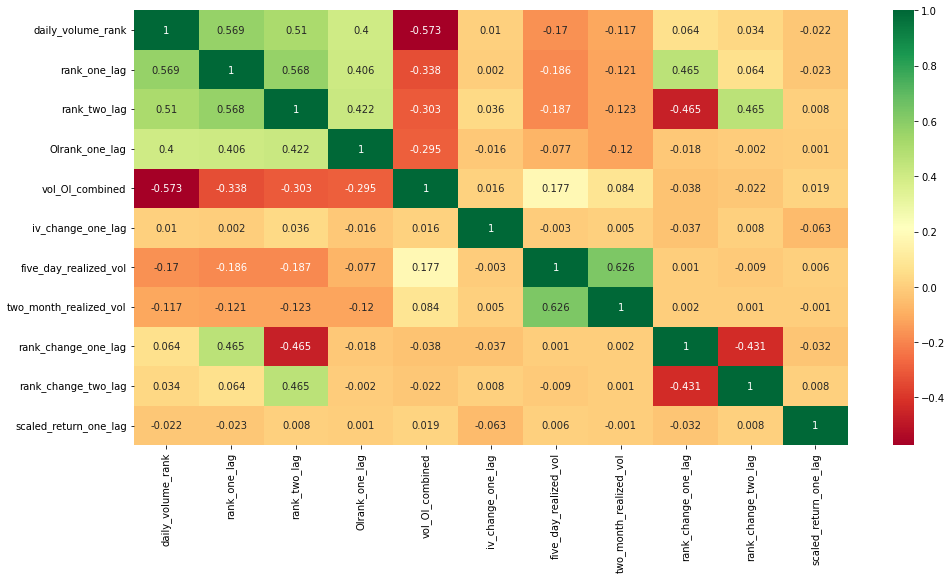

In [17]:
fig, ax = plt.subplots(figsize=(16,8)) 
sns.heatmap(df_train[(lab + features)].corr().round(3), annot = True, fmt='g', ax = ax, cmap = 'RdYlGn')
plt.show()

In [23]:
#corr_matrix.to_csv('df_corr_matrix.csv')

In [18]:
features=['rank_one_lag','rank_two_lag','OIrank_one_lag','vol_OI_combined','iv_change_one_lag',
          'five_day_realized_vol','two_month_realized_vol','rank_change_one_lag','rank_change_two_lag',
          'scaled_return_one_lag']

In [19]:
y = df_train['daily_volume_rank']
df_x = df_train[features]
X = df_x.values
colnames = df_x.columns

In [20]:
ranks = {}
def ranking(ranks,names,order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0] #sorts ranks based on minmax and order provided
    ranks = map(lambda x : np.round(x,2),ranks)
    return dict(zip(names,ranks))

### Wrapper based methods
Unlike filter based methods, wrapper based methods actually fit the features to the labels in the training set. These methods iteratively change the features in the model and evaluate their effectiveness based on a loss function. These are computationally more expensive however they have the benefit of fitting for a specific model. Some examples:
- <b>Recursive Feature Elimination</b>
- Stepwise selection


In [21]:
lr = LinearRegression(normalize=True)
lr.fit(X,y)
rfe = RFE(lr, n_features_to_select = 1 , verbose =3)
rfe.fit(X,y)
ranks['RFE'] = ranking(list(map(float,rfe.ranking_)),colnames,order=-1)

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


### Embedded methods
Embedded methods are a hybrid of both filter and wrapper based methods. They fit actual models using different combinations of features while usually applying a penalty function to perform regularization. Random forest models are usually used for tree-based methods while lasso, ridge, or elastic net regressions are applied for regression feature selection.
* <b>Lasso, Ridge</b>, Elastic Net regularizations
* <b>Random Forest </b>, Decision Tree

In [22]:
lr = LinearRegression(normalize=True)
lr.fit(X,y)
ranks['LinReg'] = ranking(np.abs(lr.coef_),colnames)

ridge = Ridge(alpha=7)
ridge.fit(X,y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_),colnames)

lasso = Lasso(alpha = 0.05)
lasso.fit(X,y)
ranks['Lasso'] = ranking(np.abs(lasso.coef_),colnames)

In [23]:
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 50  , verbose = 0,max_features=.4)
rf.fit(X,y)
ranks['RF'] = ranking(rf.feature_importances_,colnames)

## Exploring Feature Importance

In [24]:
df_ranks = pd.DataFrame.from_dict(ranks).reset_index().rename({'index':'Feature'},axis=1)
df_ranks['Mean'] = df_ranks.mean(axis=1).round(2)
df_ranks = df_ranks.sort_values('Mean',ascending=False).reset_index(drop=True)
df_ranks

,Feature,RFE,LinReg,Ridge,Lasso,RF,Mean
0,two_month_realized_vol,0.89,1.00,1.00,1.00,0.00,0.78
1,five_day_realized_vol,1.00,0.56,0.56,0.45,0.00,0.51
2,iv_change_one_lag,0.78,0.47,0.47,0.32,0.00,0.41
3,vol_OI_combined,0.11,0.00,0.00,0.00,1.00,0.22
4,scaled_return_one_lag,0.67,0.10,0.10,0.14,0.00,0.20
5,rank_one_lag,0.56,0.03,0.03,0.06,0.10,0.16
6,rank_two_lag,0.44,0.03,0.03,0.03,0.05,0.12
7,rank_change_two_lag,0.33,0.01,0.01,0.02,0.00,0.07
8,OIrank_one_lag,0.22,0.01,0.01,0.01,0.03,0.06
9,rank_change_one_lag,0.00,0.00,0.00,0.02,0.00,0.00


#### Feature selection conclusion: <br>
Based on our findings we will proceeed with the following 10 features:
* Volume Rank (one day lag) 
* Volume Rank (two day lag)
* Open Interest (one day lag)
* Open Interest and Volume Combination (one day lag) - engineered
* Implied Volatility (one day lag)
* Rolling 5 day Realized Volatility - engineered
* Rolling 2 month Realized Volatility - engineered
* Rank Change (one day lag)
* Rank Change (two day lag)
* Scaled Return (one day lag) - engineered

In [31]:
#df_ranks.to_csv('df_ranks_feature_selection.csv')

In [25]:
# import bokeh functions   
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models import NumeralTickFormatter
from bokeh.plotting import figure, show
from bokeh.plotting import reset_output
from bokeh.palettes import Set3
import math

# output inline
output_notebook()

df_ranks_ = df_ranks.copy().sort_values('Mean',ascending=True)
df_ranks_['color']=['#fafa6e' , '#c9ee73' , '#9cdf7c' , '#72cf85' , '#4abd8c' , '#23aa8f' 
                    , '#00968e' , '#008288' ,'#106e7c', '#225b6c']
# creating ColumnDataSource from DataFrame
source = ColumnDataSource(df_ranks_)

# initializing the figure
p = figure(width=1000, height=400, y_range=df_ranks_['Feature'], title='Feature Importance',
           x_axis_label='Mean', y_axis_label='Feature')

# adding vbar glyphs, passing data with ColumnDataSource
p.hbar(y='Feature', left=0, right='Mean', color = 'color' , width=0.75, source=source)

# formatting the y-axis to percents
#p.yaxis.formatter = NumeralTickFormatter(format='0%')

# rotating x-axis labels
p.xaxis.major_label_orientation = math.pi/4

# output graph
show(p)


Loading BokehJS ...

#### User defined functions necessary for backtesting

In [26]:
df_test_import = pd.read_csv("test_2018_WAAB.csv")
def top_n_volume(n,df_test=df_test_import):
    df_top_n_volume = \
    (
    df_test
        .query('daily_volume_rank <= @n')
        .groupby(['quotedate'])[['totalvol']].sum()
        .reset_index()
        .rename(columns={'totalvol':'top_' + str(n) + '_volume'})
    )
    return(df_top_n_volume)

In [27]:
def calc_top_n_ratio(n, trade_date, df_test, model=None, features=[]):
    
    # grabbing top-n volume for each day in backtest
    df_top_n = top_n_volume(n)
    
    # grabbing feature observations for trade_date
    df_prediction = df_test.query('quotedate == @trade_date').copy()
    
    # selecting features from df_X
    df_X = df_prediction[features]
    
    # calculating model predictions
    if model is not None:
        df_prediction['prediction'] = model.predict(df_X) # predictions base on model
    else:
        df_prediction['prediction'] = df_prediction['rank_one_lag'] # simple-rule based
    
    # sorting by predicted rank
    df_prediction = df_prediction.sort_values(['prediction'])
    # calculating predicted top-n volume
    predicted_top_n_volume = df_prediction.head(n)['totalvol'].sum()
    # querying for actual top-n volume
    actual_top_n_volume = df_top_n.query('quotedate == @trade_date')['top_' + str(n) + '_volume'].values[0]
    
    # return the top-n-ratio
    return(predicted_top_n_volume / actual_top_n_volume)

In [28]:
def backtest(n, df_test, model=None, features=[]):
    # all trade dates in backtest period
    trade_dates = df_test['quotedate'].unique().tolist()
    
    # calculating all top-n ratios
    top_n_ratios = []
    for ix_trade_date in trade_dates:
        top_n_ratios.append(calc_top_n_ratio(n, ix_trade_date, df_test, model, features))

    # creating a dataframe of daily top-n ratios
    df_daily = pd.DataFrame({
        'trade_date':trade_dates,
        'top_'+str(n)+'_volume': np.round(top_n_ratios, 3),
    })

    # calculating summary statsics of top-n ratios during backtest period
    df_stats = pd.DataFrame({
        'model':[str(model)],
        'average':[np.mean(top_n_ratios).round(3)],
        'std_dev':[np.std(top_n_ratios).round(3)],
        'minimum':[np.min(top_n_ratios).round(3)],
        'maximum':[np.max(top_n_ratios).round(3)],
    })

    return([df_daily, df_stats])

## Supervised Models and Hyperparameter Tuning
<a id='variety_models'></a>

We created predictions using:

* Simple rule-based
* Linear Regression
* **Lasso**
* **KNN**
* **Random Forest**
* **XGBoost:**

and hypertuned the bold-highlighted above:

### Lasso


We hypertuned the alpha parameter for Lasso, using a 10 fold CrossValidation of values between 0.1 and 0.3 which resulted in alpha = 0.23

In [29]:
lasso_tuning = pd.read_csv('LassoTuning.csv')
lasso_tuning.drop(columns='Unnamed: 0',inplace=True)
lasso_tuning

,alpha,cvs_mean
0,0.100000,0.519594
1,0.122222,0.519589
2,0.144444,0.519626
3,0.166667,0.519663
4,0.188889,0.519692
5,0.211111,0.519709
6,0.233333,0.519712
7,0.255556,0.519710
8,0.277778,0.519708
9,0.300000,0.519706


### KNN

Used a 10-fold CrossValidation to tune n_neighbors. Best result was n_neighbors = 400

### Random Forest

Tuned max_depth using a 10-fold CV for values between 1 and 20 which returned max_depth=6 as the parameter with best results

### Gradient Boosted Treees for Regression (XGBoost):

From the above results, we got a good sense of the best ranges for hyperparameteres and selected the below to perform GridSearch:

<b>Max Depth:</b> 5,6,7<br>
<b>Learning Rate:</b> 0.1,0.2,0.3,0.4<br>
<b>N Estimators:</b> 10,100,200<br>

In [30]:
params = { 'max_depth': [5,6,7],
           'learning_rate': [0.1,0.2,0.3,0.4],
           'n_estimators': [10, 100, 200],
           }

In [31]:
gridsearch=pd.read_csv('GridSearchCV_XGBoost.csv')
gridsearch=gridsearch[(gridsearch['rank_test_score']==1)]
print(gridsearch['params'].values)

["{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}"]


In [32]:
r2_MSE_models = pd.read_csv('r2_MSE_Results.csv')
r2_MSE_models.drop(columns='Unnamed: 0',inplace=True)
r2_MSE_models=r2_MSE_models[r2_MSE_models["Model"].isin(['simple-rule','linear_regression','lasso','knn','random_forest','xg_model'])]
r2_MSE_models.reset_index(inplace=True)
r2_MSE_models.drop(columns='index',inplace=True)
r2_MSE_models

,Model,R2,MSE
0,xg_model,0.947470,393.971972
1,random_forest,0.945303,410.223896
2,knn,0.945235,410.732664
3,lasso,0.546245,3403.118920
4,linear_regression,0.545325,3410.019735


From these results we can observe that the regression based models are a poor representation of the behavior characterized by relatively low R-squared and high mean-square error scores.

<a id='NN_models'></a>
## Neural Networks

In [33]:
import random
import tensorflow as tf
import datetime
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [34]:
df_train = pd.read_csv('train_2017_WAAB.csv')
df_test = pd.read_csv('test_2018_WAAB.csv')

In [36]:
df_X = df_train[features]
df_y = df_train[['daily_volume_rank']]

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.20, random_state=0)

In [38]:
model = Sequential()
model.add(Dense(units=128, input_dim=len(X_train.columns), activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(1))

# model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

## Neural Network Model Configuration <br>
When leveraging a neural network model, we need to consider the a few components: <br>
1. The loss function: In our analysis we are using the **MSE loss function**
2. The optimizer used: **Adam** vs **RMSProp**
3. The activation function applied: **Relu** vs **Sigmoid**
4. Tuning of hyperparameters


### Selecting an Optimizer: Adam vs RMSProp
The optimizer determines the stochastic gradient descent algorithm used when fitting the model. In our analysis, we considered the Adam and RMSprop optimizers. The Adam and RMSprop optimizers are closely related with a few key differences: 
- RMSprop updates the parameter estimates using a momentum on the rescaled gradient. Adam on the other hand updates the estimates directly using a rolling average of the moments of the gradient. 
- RMSprop lacks a bias-correction term


**We compared the Adam and RMS optimizers in terms of goodness of fit which we measured using R-squared and the mean square error.**

In [39]:
model = Sequential()
model.add(Dense(units=128, input_dim=len(X_train.columns), activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(1))

optimizers = ['rmsprop', 'adam']
scores_mse_lst = []
scores_r2_lst = []
scores_lst = []

for ix_opt in optimizers:
    
    if ix_opt == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop() 
    elif ix_opt == 'adam':
        opt = tf.keras.optimizers.Adam() 
    else:
        print("Invalid optimizer name")
        
    # Compile model:
    model.compile(optimizer=opt, loss='mse', metrics=['mae']) 
    model.fit(X_train, y_train, 
                          epochs=50,
                          batch_size=256,
                          verbose=0)
  
    # In scores, the first value is the MSE, the second is R^2.
    scores = model.evaluate(X_test, y_test)
    scores_lst.append(scores)
    scores_mse_lst.append(sklearn.metrics.mean_squared_error(y_test, model.predict(X_test)))
    scores_r2_lst.append(sklearn.metrics.r2_score(y_test, model.predict(X_test)))
   
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    
print("Testing rmsprop vs adam optimizers done: ")
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))
    
df_optimizers_results = pd.DataFrame({'Optimizer':optimizers, 'mse':scores_mse_lst, 'r2':scores_r2_lst})
df_optimizers_results

392/392 [==============================] - 1s 1ms/step - loss: 471.7740 - mae: 16.2139
Test loss: 471.7739562988281
Test accuracy: 16.213899612426758
392/392 [==============================] - 1s 1ms/step - loss: 291.6950 - mae: 12.2961
Test loss: 291.69500732421875
Test accuracy: 12.296140670776367
Testing rmsprop vs adam optimizers done: 
Current date and time : 
2022-08-01 15:03:09


,Optimizer,mse,r2
0,rmsprop,471.773958,0.937711
1,adam,291.695042,0.961487


**Selecting an Activation Function**

Note - using *Adam optimizer* only in this section
<br>
<br>
Fit using various activaton functions: <br>
i.	ReLu activation: max(x, 0) <br>
ii.	Sigmoid activation function: sigmoid(x) = 1 / (1 + exp(-x)) <br>

In [40]:
model = Sequential()
model.add(Dense(units=128, input_dim=len(X_train.columns), activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(1))

act_funcs = ['relu', 'sigmoid']
scores_mse_lst = []
scores_r2_lst = []
scores_lst = []

for ix_actfunc in act_funcs:
       
    model = Sequential()
    model.add(Dense(units=128, input_dim=len(X_train.columns), activation=ix_actfunc))
    model.add(Dense(units=128, activation=ix_actfunc))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae']) 

    model.fit(X_train, y_train, 
                          epochs=50,
                          batch_size=256,
                          verbose=0)
  
    # In scores, the first value is the MSE, the second is R^2.
    scores = model.evaluate(X_test, y_test)
    scores_lst.append(scores)
    scores_mse_lst.append(sklearn.metrics.mean_squared_error(y_test, model.predict(X_test)))
    scores_r2_lst.append(sklearn.metrics.r2_score(y_test, model.predict(X_test)))

    print('Test loss:', scores[0])
    print('Test MSE:', scores[1])
    
print("Activation functions testing done: ")
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))
    
# load results into dataframe:
df_act_func_results = pd.DataFrame({'Activation_Func':act_funcs, 'mse':scores_mse_lst, 'r2':scores_r2_lst})
df_act_func_results

392/392 [==============================] - 1s 1ms/step - loss: 783.8728 - mae: 21.0055
Test loss: 783.872802734375
Test MSE: 21.00552749633789
392/392 [==============================] - 1s 1ms/step - loss: 643.0723 - mae: 18.9151
Test loss: 643.072265625
Test MSE: 18.915128707885742
Activation functions testing done: 
Current date and time : 
2022-08-01 15:03:49


,Activation_Func,mse,r2
0,relu,783.872807,0.896504
1,sigmoid,643.072077,0.915095


As shown in the table above, the **ReLu activation function** results in the **lowest MSE and highest R^2 score**.

### Hyperparameter tuning: Learning Rate
<br>
The learning rate controls how much the weights are updated after each iteration. Essentially, it controls how quickly the algorithm adapts to the problem. 
<br>
The following learning rates were tested and the resulting R-squared and MSE were compared:<br>
<br>
Learning rates tested: (0.001, 0.002, 0.003, 0.004)

**However, before we jump into tuniung the learning rate, let's quick check that 50 epochs results in a sufficient reduction in training loss and mean absolute error.**
<br>
The two charts below measure the training loss and MAE by epoch with a small learning rate of 0.0005. A smaller learning rate generally requires a larger number of epoch. Using the smallest learning rate, 0.0005, will help us determine if 50 epoch is suficient.

**Check the number of epochs is sufficient:**

In [41]:
model = Sequential()
model.add(Dense(units=128, input_dim=len(X_train.columns), activation=ix_actfunc))
model.add(Dense(units=128, activation=ix_actfunc))
model.add(Dense(1))

opt = tf.keras.optimizers.Adam(learning_rate = 0.0005)

model.compile(optimizer=opt, loss='mse', metrics=['mae']) 

model_check_epoch = model.fit(X_train, y_train, 
                          epochs=50,
                          batch_size=256,
                          verbose=0)

df_model_check_epoch = pd.DataFrame({'Loss':model_check_epoch.history['loss'], 'MAE':model_check_epoch.history['mae'], 'Epochs':np.linspace(1, 50, 50)})
df_model_check_epoch
#df_model_check_epoch.to_csv('df_model_check_epoch_loss_mae.csv')

,Loss,MAE,Epochs
0,27708.535156,142.431198,1.0
1,25035.332031,133.498428,2.0
2,23009.623047,126.715439,3.0
3,21196.763672,120.667473,4.0
4,19536.027344,115.123596,5.0
...,...,...,...
45,757.333191,21.838167,46.0
46,726.281921,21.336241,47.0
47,709.902710,21.023544,48.0
48,687.020813,20.647814,49.0


In [42]:
from bokeh.layouts import column
from bokeh.io import export_png,show,output_notebook
from bokeh.plotting import figure
from bokeh.palettes import Dark2_5 as palette
import itertools
cds = ColumnDataSource(df_model_check_epoch)

output_notebook()

# defining multiple plots
p1 = figure(width=500, height=300, title='MAE',      #x_axis_type='integer'
           x_axis_label='Epochs', y_axis_label='Mean Absolute Error')
colors = itertools.cycle(palette) 
#for i,NN in enumerate(best_NNs):
p1.line(x='Epochs', y='MAE', source=cds,color=next(colors))

p2 = figure(width=500, height=300, title='Loss', 
            x_axis_label='Epochs', y_axis_label='Loss')
colors = itertools.cycle(palette) 
#for i,NN in enumerate(best_NNs):
p2.line(x='Epochs', y='Loss', source=cds,color=next(colors))
#p2.yaxis.formatter = NumeralTickFormatter(format='0%')

# putting them together using column()
show(column(p1, p2))

Loading BokehJS ...

**As we see above, the training losss and MAE begin to level of and decline slowly just before 50 epoch. We will proceeed to use 50 epoch in tuning the learning rate.**

#### Tuning the learning rate in Adam optimizer

In [43]:
model = Sequential()
model.add(Dense(units=128, input_dim=len(X_train.columns), activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(1))

learn_rates = [0.001, 0.002, 0.003, 0.004]
scores_mse_lst = []
scores_r2_lst = []

for ix_rate in learn_rates:
    
    # Initilize optimizer - using default values for all other parameters except learning_rate
    opt = tf.keras.optimizers.Adam(learning_rate=ix_rate) 

    model.compile(optimizer=opt, loss='mse', metrics=['mae']) 
    # model_fit_test = 
    model.fit(X_train, y_train, 
                          epochs=50,
                          batch_size=256,
                          verbose=0)
  
    # In scores, the first value is the MSE, the second is R^2.
    scores = model.evaluate(X_test, y_test)
    scores_mse_lst.append(sklearn.metrics.mean_squared_error(y_test, model.predict(X_test)))
    scores_r2_lst.append(sklearn.metrics.r2_score(y_test, model.predict(X_test)))
#     scores_mse_lst.append(scores[0])
#     scores_r2_lst.append(scores[1])
    
    # putting both mse and r2 values in a list (I think this is less easy to use later)
    scores_lst.append(scores)

    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

    
print("Adam optimizer done: ")
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))
    

    
#     scores_mse_lst.append(sklearn.metrics.mean_squared_error(y_test, model.predict(X_test)))
#     scores_r2_lst.append(sklearn.metrics.r2_score(y_test, model.predict(X_test)))    
#scores_lst
df_lrate_adam_results = pd.DataFrame({'learn_rate':learn_rates, 'mse':scores_mse_lst, 'r2':scores_r2_lst})
df_lrate_adam_results

392/392 [==============================] - 0s 768us/step - loss: 2761.9280 - mae: 39.1087
Test loss: 2761.927978515625
Test accuracy: 39.10872268676758
392/392 [==============================] - 0s 709us/step - loss: 319.1188 - mae: 13.3203
Test loss: 319.1187744140625
Test accuracy: 13.320331573486328
392/392 [==============================] - 0s 714us/step - loss: 320.9965 - mae: 13.1637
Test loss: 320.99652099609375
Test accuracy: 13.16368293762207
392/392 [==============================] - 0s 704us/step - loss: 300.2229 - mae: 12.3954
Test loss: 300.2229309082031
Test accuracy: 12.395438194274902
Adam optimizer done: 
Current date and time : 
2022-08-01 15:45:23


,learn_rate,mse,r2
0,0.001,2761.928923,0.635340
1,0.002,319.118855,0.957866
2,0.003,320.996481,0.957618
3,0.004,300.223019,0.960361


**As shown in the table above, a learning rate = 0.002 results in the lowest MSE and highest R-squared score.**


## Neural network model configuration conclusion:
**Choice of optimizer**: Adam <br>
***Choice of activation funciton***: relu <br>
***Learning Rate***: .002 <br>


In [44]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

#### Define Neural Network models

In [45]:
# User defined constructor class
class neural_net:
    def __init__(self,name:str, layers:list,activation:list,input_dim:int,optimizer:tf.keras.optimizers = 'rmsprop', loss:str = 'mse', metrics:list = ['mae'],activity_regularizer:l2=None,dropout:Dropout=None,normalize:bool=False):
        """Constructor class for Forward Feed Neural Network
        ##### parameters
        name:str name of the neural network i.e. deep, shallow, simple, etc.
        layers:list list of ints describing the units in each layer i.e. [8,16] is two layer with 8 nodes in 1st and 16 in seconds
        activation: list of strings describing each layer's activation function i.e. ['relu','relu']
        input_dim: int number of features to input
        optimizer:str is the optimizer for the complier 'rmsprop' or 'adam'
        loss:str loss function such as 'mse'
        metrics:list is list of output metrics for complier
        activity_regularizer:l2 is l2 regulizer to pass into each layer after it's created (applies to all layers)
        dropout:Dropout=None adding a drop out regulizer for each layer i.e. Dropout(rate=0.3, seed=100)
        normalize:bool=False normalization of the input data
        """
        self.name = name
        self.layers = layers
        self.activation = activation
        self.input_dim = input_dim
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        self.activity_regularizer = activity_regularizer
        self.dropout = dropout
        self.normalize = normalize
        self._construct_layers(layers,activation,input_dim,activity_regularizer,dropout)
        self._compiler(optimizer,loss,metrics)
    def __str__(self):
        return self.name
    def _construct_layers(self,layers,activation,input_dim,activity_regularizer,dropout):
        for i,n in enumerate(layers):
            if i ==0:
                model = Sequential()
                model.add(Dense(units=n, input_dim=input_dim, activation=activation[i],activity_regularizer=activity_regularizer))
            else:
                model.add(Dense(units=n, activation=activation[i],activity_regularizer=activity_regularizer))
            if dropout is not None:
                model.add(dropout)
        model.add(Dense(1))
        self.model = model
    def _compiler(self,optimizer,loss,metrics):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics) 
    def fit(self,X_train,y_train,epochs=50,batch_size=252,verbose=1):
        if self.normalize:
            self.mu = X_train.mean()
            self.std = X_train.std()
            self.X_train = (X_train - self.mu) / self.std
        else:
            self.X_train = X_train
        return self.model.fit(self.X_train, y_train, 
                          epochs=epochs,
                          batch_size=batch_dim,
                          verbose=verbose)
    def evaluate(self,X_test,y_test):
        if self.normalize:
            self.X_test = (X_test - self.mu) /self.std
        else:
            self.X_test = X_test
        self.score = self.model.evaluate(self.X_test,y_test)
        return self.score
    def predict(self,df_X):
        if self.normalize:
            df_X = (df_X - self.mu) / self.std
        return self.model.predict(df_X)

We tested 3 architectures:
* deep: 2 layers with 128 nodes in each layer
* simple: single layer with 16 nodes
* shallow: 2 layers with 16 nodes in first layer and 32 in second layer

On these 3 architectures we tested normalization, and two forms of regularization:
* Normalization
* Drop out Regularization
* L2 Regularization


In [46]:
models = {}
models_norm = {}
models_doReg={}
models_l2Reg={}
input_dim=10
do  = Dropout(rate=0.3, seed=100)
regL2 = l2(0.0005)

# Initilize optimizer
opt = Adam(learning_rate=0.002) 

#Define models
deep_model = neural_net('deep',[128,128],['relu','relu'],input_dim=input_dim,optimizer=opt)
simple_model = neural_net('simple',[16],['relu'],input_dim=input_dim,optimizer=opt)
shallow_model = neural_net('shallow',[16,32],['relu','relu'],input_dim=input_dim,optimizer=opt)

deep_model_norm = neural_net('deep_norm',[128,128],['relu','relu'],input_dim=input_dim,normalize = True,optimizer=opt)
simple_model_norm = neural_net('simple_norm',[16],['relu'],input_dim=input_dim, normalize = True,optimizer=opt)
shallow_model_norm = neural_net('shallow_norm',[16,32],['relu','relu'],input_dim=input_dim, normalize = True,optimizer=opt)

deep_model_doReg = neural_net('deep_doReg',[128,128],['relu','relu'],input_dim=10,dropout=do,optimizer=opt)
simple_model_doReg = neural_net('simple_doReg',[16],['relu'],input_dim=10,dropout=do,optimizer=opt)
shallow_model_doReg = neural_net('shallow_doReg',[16,32],['relu','relu'],input_dim=10,dropout=do,optimizer=opt)

deep_model_regL2 = neural_net('deep_regL2',[128,128],['relu','relu'],input_dim=input_dim,activity_regularizer=regL2,optimizer=opt)
simple_model_regL2 = neural_net('simple_regL2',[16],['relu'],input_dim=input_dim,activity_regularizer=regL2,optimizer=opt)
shallow_model_regL2 = neural_net('shallow_regL2',[16,32],['relu','relu'],input_dim=input_dim,activity_regularizer=regL2,optimizer=opt)

all_nn_models = [deep_model,simple_model,shallow_model,deep_model_norm,simple_model_norm,
                 shallow_model_norm,deep_model_doReg,simple_model_doReg,shallow_model_doReg,
                 deep_model_regL2,simple_model_regL2 ,shallow_model_regL2]


## Fit the neural network models

In [47]:
#%%time
num_epochs = 50
batch_dim  =  1024
model_fitted = {}
for model in all_nn_models:
    print("Fitting {} model".format(model.name))
    model_fitted.update({model.name:model.fit(X_train, y_train, 
                          epochs=num_epochs,
                          batch_size=batch_dim,
                          verbose=0)})

Fitting deep model
Fitting simple model
Fitting shallow model
Fitting deep_norm model
Fitting simple_norm model
Fitting shallow_norm model
Fitting deep_doReg model
Fitting simple_doReg model
Fitting shallow_doReg model
Fitting deep_regL2 model
Fitting simple_regL2 model
Fitting shallow_regL2 model


In [48]:
# Generating data CSVs for charts
df_loss = pd.DataFrame()

for mo in all_nn_models:
    m=mo.name
    df_loss[m] = model_fitted[m].history['loss']
df_loss=df_loss.reset_index().rename({'index':'epochs'},axis=1)
#df_loss.to_csv('df_loss.csv')
df_loss

,epochs,deep,simple,shallow,deep_norm,simple_norm,shallow_norm,deep_doReg,simple_doReg,shallow_doReg,deep_regL2,simple_regL2,shallow_regL2
0,0,48388.296875,28109.845703,36598.277344,9303.798828,28476.976562,19833.867188,530640.312500,530715.437500,836855.250000,277059.750000,186663.031250,123422.828125
1,1,2891.432861,3134.349365,2526.094238,1238.567993,22274.367188,3628.488281,7209.694824,6902.499023,30706.677734,33772.578125,48444.449219,37672.382812
2,2,2182.305176,2950.679443,2267.476318,688.416748,14590.734375,2303.184570,5894.916504,6144.518555,21494.437500,23033.890625,44067.167969,29754.935547
3,3,2117.699707,2671.874756,2161.409668,562.175598,9006.611328,1609.231689,5159.417969,6010.116699,16441.296875,18456.726562,40374.187500,24235.322266
4,4,2081.049316,2528.053955,2106.362549,498.299652,6044.070801,1199.498535,4736.121094,5842.062988,12646.377930,15268.787109,36964.777344,19945.525391
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,45,1375.929932,1783.180542,797.195984,289.118561,844.000793,299.525421,2325.853516,4195.607422,5183.110840,751.052795,1979.004761,1051.208496
46,46,1340.370972,1676.223022,765.403748,288.658112,828.554626,298.222656,2340.846191,4107.296875,5029.459473,800.960999,1928.504761,1001.478149
47,47,1324.911499,1662.119141,776.223694,288.492004,813.884827,298.108856,2322.943604,4084.931641,5162.593750,760.992981,1901.808716,1000.865967
48,48,5747.848145,1643.697388,837.236206,288.808441,800.145325,297.897797,2302.344727,3990.497070,5134.073730,778.060059,1844.135986,943.525513


In [49]:
df_mae = pd.DataFrame()

for mo in all_nn_models:
    m = mo.name
    df_mae[m] = model_fitted[m].history['mae']
df_mae=df_mae.reset_index().rename({'index':'epochs'},axis=1)
#df_mae.to_csv('df_mae.csv')
df_mae

,epochs,deep,simple,shallow,deep_norm,simple_norm,shallow_norm,deep_doReg,simple_doReg,shallow_doReg,deep_regL2,simple_regL2,shallow_regL2
0,0,109.702263,89.324173,80.087128,69.814468,145.538177,114.218094,223.447205,239.056580,323.213531,145.314606,172.475616,128.742096
1,1,39.953423,43.728943,38.616058,26.588980,126.848083,45.918282,66.232773,64.155388,111.031219,39.083649,45.750385,42.735329
2,2,35.636536,42.486229,36.229809,20.524273,100.401703,36.912468,59.227745,60.711357,96.456306,35.877907,41.786613,39.896851
3,3,35.088684,40.313354,35.333488,18.685768,77.152214,30.784866,56.001572,59.891468,84.968758,34.192280,39.874950,39.165287
4,4,34.783741,39.004124,34.829781,17.436375,61.790730,26.688875,53.605526,59.182423,78.481461,33.738979,37.994598,37.523121
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,45,27.984316,32.378117,21.236727,12.177011,23.154882,12.644621,36.986523,49.555813,55.744862,19.796276,32.174122,24.587408
46,46,27.603279,31.172567,20.751379,12.185130,22.957418,12.596432,37.102200,49.019375,55.057346,20.823795,31.961790,23.957376
47,47,27.537271,31.082693,21.011595,12.165449,22.778015,12.592150,36.975487,48.817348,55.169945,20.263727,31.916666,23.921982
48,48,46.490490,30.923330,22.016850,12.162653,22.595129,12.566150,36.838463,48.344238,54.955894,20.640480,31.543783,23.186964


## Backtesting the models

In [50]:
lst_score = []
backtest_results = []
model_nm_lst = []
df_features = df_train[features]
df_label = df_train[['daily_volume_rank']]

for model in all_nn_models:
    score = model.evaluate(X_test, y_test)
    lst_score.append(score)
    backtest_results.append(backtest(10, df_test, model, features))
    model_nm_lst.append(model.name)


392/392 [==============================] - 1s 1ms/step - loss: 870.1373 - mae: 22.2303


In [51]:
df_backtest = pd.DataFrame(columns = backtest_results[0][1].columns)

for i in range(0, (len(backtest_results))):
    print(i)
    df_append = backtest_results[i][1]
    df_backtest = df_backtest.append(df_append)
                                                                         
print("Backtest statistics for each model: ")
df_backtest.reset_index(drop=True).sort_values('average')

0
1
2
3
4
5
6
7
8
9
10
11
Backtest statistics for each model: 


,model,average,std_dev,minimum,maximum
8,shallow_doReg,0.148,0.040,0.059,0.282
0,deep,0.194,0.056,0.076,0.417
6,deep_doReg,0.536,0.148,0.203,0.937
4,simple_norm,0.731,0.132,0.356,0.999
5,shallow_norm,0.761,0.163,0.335,1.000
10,simple_regL2,0.763,0.107,0.442,0.974
7,simple_doReg,0.783,0.105,0.442,0.983
1,simple,0.884,0.073,0.608,1.000
11,shallow_regL2,0.889,0.060,0.686,0.995
9,deep_regL2,0.903,0.073,0.531,1.000


As per the above results the Neural Network models we will be using are:

* Shallow model with L2 regularization
* Deep model with L2 regularization
* Deep model with normalization

In [52]:
selected_NN=[shallow_model_regL2, deep_model_regL2, deep_model_norm]

#### Effect of number of epochs: MAE and Loss

In [53]:
from bokeh.layouts import column
from bokeh.io import export_png,show,output_notebook
from bokeh.plotting import figure
from bokeh.palettes import Dark2_5 as palette
import itertools

df_loss = pd.read_csv('df_loss.csv',index_col=0)
df_mae = pd.read_csv('df_mae.csv',index_col=0)

best_NNs=['shallow_regL2', 'deep_regL2', 'deep_norm']

output_notebook()

# defining multiple plots
p1 = figure(width=500, height=300, title='MAE',      #x_axis_type='integer'
           x_axis_label='Epochs', y_axis_label='Mean Absolute Error')
colors = itertools.cycle(palette) 
for i,NN in enumerate(best_NNs):
    p1.line(x='epochs', y=NN,legend_label=NN, source=df_mae,color=next(colors),)

p2 = figure(width=500, height=300, title='Loss', 
            x_axis_label='Epochs', y_axis_label='Loss')
colors = itertools.cycle(palette) 
for i,NN in enumerate(best_NNs):
    p2.line(x='epochs', y=NN,legend_label=NN, source=df_loss,color=next(colors))
#p2.yaxis.formatter = NumeralTickFormatter(format='0%')

# putting them together using column()
show(column(p1, p2))

Loading BokehJS ...

## Model Comparison

In [54]:
df_test = pd.read_csv('test_2018_WAAB.csv')

In [55]:
df_features_test = df_test[features]
df_label_test = df_test[['daily_volume_rank']]

In [56]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#### R-squared and MSE

In [57]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(df_features, np.ravel(df_label.values))
#print("Linear Regression R2 Score: {}".format(np.round(linear_regression.score(df_features, df_label),5)))

df_features = df_train[features]
df_label = df_train[['daily_volume_rank']]
lasso = Lasso(alpha=0.23)
lasso.fit(df_features, np.ravel(df_label.values))
#print("Lasso R2 Score: {}".format(np.round(lasso.score(df_features, df_label),5)))

from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=400)
knn.fit(df_features, np.ravel(df_label.values))
#print("KNN R2 Score: {}".format(np.round(knn.score(df_features, df_label),5)))
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
df_features = df_train[features]
df_label = df_train[['daily_volume_rank']]
random_forest = RandomForestRegressor(n_estimators = 100, max_depth=6)
random_forest.fit(df_features, np.ravel(df_label.values))
#print("Random Forest R2 Score: {}".format(np.round(random_forest.score(df_features, df_label),5)))

from xgboost import XGBRegressor
xg_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=0,verbosity=0)
xg_model.fit(df_features, df_label)

from xgboost import XGBRegressor

xg_model = XGBRegressor(random_state = 0,use_label_encoder=False, eval_metric='logloss',
                    learning_rate = 0.1, max_depth = 5, n_estimators=100,verbosity = 0)
xg_model.fit(df_features, df_label)
#print("XG Boost R2 Score: {}".format(np.round(xg_model.score(df_features, df_label),5)))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             use_label_encoder=False, validate_parameters=1, verbosity=0)

In [58]:
models = [linear_regression,lasso,knn,random_forest,xg_model]+selected_NN

In [59]:
model_names=['linear_regression','lasso','knn','random_forest','xg_model']+['shallow_model_regL2','deep_model_regL2','deep_model_norm']

In [60]:
lst_models=[]
lst_r2=[]
lst_mse=[]

for mdl in models:
    r2 = sklearn.metrics.r2_score(df_label_test, mdl.predict(df_features_test))
    mse= sklearn.metrics.mean_squared_error(df_label_test, mdl.predict(df_features_test))

    lst_models.append(str(mdl))
    lst_r2.append(r2)
    lst_mse.append(mse)

#### Comparison of R-square and MSE

In [61]:
df_scores = pd.DataFrame({'Model':model_names, 'R2':lst_r2, 'MSE':lst_mse}) 

print("Scores of various models fit on df_train: ")
df_scores=df_scores.sort_values('R2',ascending=False)
#df_scores = pd.read_csv('last_second_mse_scores.csv',index_col=0)
df_scores

Scores of various models fit on df_train: 


,Model,R2,MSE
4,xg_model,0.947470,393.971975
3,random_forest,0.945253,410.594366
2,knn,0.945235,410.732664
7,deep_model_norm,0.945014,412.390898
6,deep_model_regL2,0.923177,576.164341
5,shallow_model_regL2,0.889815,826.376148
1,lasso,0.546245,3403.118920
0,linear_regression,0.545325,3410.019735


In [62]:
df_r2_MSE_Results = df_scores.sort_values('MSE', ascending = True) #vert. average

df_r2_MSE_Results = df_scores.sort_values('R2', ascending = False) #vert. average

# import bokeh functions   
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models import NumeralTickFormatter
from bokeh.plotting import figure, show
from bokeh.plotting import reset_output
import math

# output inline
output_notebook()

#df_ranks_ = df_ranks.copy()
df_r2_MSE_Results['color']=['#fafa6e' , '#c9ee73' , '#9cdf7c' , '#72cf85' , '#4abd8c' , '#23aa8f' 
                    , '#00968e' , '#008288']# ,'#106e7c', '#225b6c', '#23596a', '#2a4858']
# creating ColumnDataSource from DataFrame
source = ColumnDataSource(df_r2_MSE_Results)

# initializing the figure
p1 = figure(width=1000, height=400, x_range=df_r2_MSE_Results['Model'], title='Goodness of Models Fit Comparison by R-squared',
           y_axis_label='R-squared', x_axis_label='Model')

# adding vbar glyphs, passing data with ColumnDataSource
#p.hbar(x='model', bottom=0, top='average', color = 'color' , width=0.75, source=source)
p1.vbar(x='Model', bottom=0, top='R2', color='color', width=0.75, source=source)

# formatting the y-axis to percents
#p.yaxis.formatter = NumeralTickFormatter(format='0%')

# rotating x-axis labels
p1.xaxis.major_label_orientation = math.pi/4


#df_ranks_ = df_ranks.copy()
df_r2_MSE_Results['color']=['#fafa6e' , '#c9ee73' , '#9cdf7c' , '#72cf85' , '#4abd8c' , '#23aa8f' 
                    , '#00968e' , '#008288']# ,'#106e7c', '#225b6c', '#23596a', '#2a4858']
# creating ColumnDataSource from DataFrame
source = ColumnDataSource(df_r2_MSE_Results)

# initializing the figure
p2 = figure(width=1000, height=400, x_range=df_r2_MSE_Results['Model'], title='Goodness of Models Fit Comparison by Mean Square Error',
           y_axis_label= 'MSE', x_axis_label='Model')

# adding vbar glyphs, passing data with ColumnDataSource
#p.hbar(x='model', bottom=0, top='average', color = 'color' , width=0.75, source=source)
p2.vbar(x='Model', bottom=0, top='MSE', color='color', width=0.75, source=source)

# formatting the y-axis to percents
#p.yaxis.formatter = NumeralTickFormatter(format='0%')

# rotating x-axis labels
p2.xaxis.major_label_orientation = math.pi/4

# output graph
show(column(p1, p2))

Loading BokehJS ...

In [85]:
#pd.DataFrame(df_scores).to_csv('r2_MSE_Results.csv')

## Running backtest and compiling results

In [65]:
pd.read_csv('Backtest_results.csv',index_col=0).drop(['minimum','maximum'],axis=1).sort_values('average').reset_index(drop=True)

,model,average,std_dev
0,Rule based,0.635,0.100
1,linear_regression,0.932,0.036
2,lasso,0.933,0.036
3,shallow_model_regL2,0.971,0.020
4,deep_model_regL2,0.989,0.011
5,knn,0.998,0.006
6,random_forest,0.998,0.006
7,xg_model,0.998,0.006
8,deep_model_norm,0.998,0.006


In [66]:
backtests=[]

df_backtest = pd.DataFrame(columns=['model','average','std_dev','minimum','maximum'])

for mdl in [None]+models:
    backtest_output=backtest(25, df_test, mdl, features)[1]
    #print(backtest_output)
    backtests=[].append(backtest_output)
    df_backtest=pd.concat([df_backtest, backtest_output], axis=0)
#df_backtest = pd.DataFrame({'model':lst_models,'average':lst_avg,'std_dev':lst_std,'minimum':lst_min,'maximum':lst_max})
    
df_backtest['model']=["Rule based"]+model_names
df_backtest

,model,average,std_dev,minimum,maximum
0,Rule based,0.635,0.100,0.307,0.882
0,linear_regression,0.932,0.036,0.812,0.993
0,lasso,0.933,0.036,0.808,0.993
0,knn,0.998,0.006,0.927,1.021
0,random_forest,0.998,0.006,0.927,1.021
0,xg_model,0.998,0.006,0.925,1.019
0,shallow_model_regL2,0.938,0.031,0.804,0.996
0,deep_model_regL2,0.975,0.020,0.837,1.000
0,deep_model_norm,0.998,0.007,0.926,1.020


In [67]:
df_backtest.drop(['minimum','maximum'],axis=1).sort_values('average',ascending=False).reset_index(drop=True)

,model,average,std_dev
0,knn,0.998,0.006
1,random_forest,0.998,0.006
2,xg_model,0.998,0.006
3,deep_model_norm,0.998,0.007
4,deep_model_regL2,0.975,0.020
5,shallow_model_regL2,0.938,0.031
6,lasso,0.933,0.036
7,linear_regression,0.932,0.036
8,Rule based,0.635,0.100


In [68]:
df_Backtest_Results = df_backtest.sort_values('average', ascending = False) #vert. average

# output inline
output_notebook()

#df_ranks_ = df_ranks.copy()
df_Backtest_Results['color']=['#fafa6e' , '#c9ee73' , '#9cdf7c' , '#72cf85' , '#4abd8c' , '#23aa8f' 
                    , '#00968e' , '#008288','#106e7c']# , '#225b6c', '#23596a', '#2a4858']
# creating ColumnDataSource from DataFrame
source = ColumnDataSource(df_Backtest_Results)

# initializing the figure
p = figure(width=1000, height=400, x_range=df_Backtest_Results['model'], title='Comparisopn by Average Top n',
           y_axis_label='Average Top n Ratio', x_axis_label='Model')

# adding vbar glyphs, passing data with ColumnDataSource
#p.hbar(x='model', bottom=0, top='average', color = 'color' , width=0.75, source=source)
p.vbar(x='model', bottom=0, top='average', color='color', width=0.75, source=source)

# formatting the y-axis to percents
#p.yaxis.formatter = NumeralTickFormatter(format='0%')

# rotating x-axis labels
p.xaxis.major_label_orientation = math.pi/4

# output graph
show(p)

Loading BokehJS ...